In [13]:
import cv2
import os
from pathlib import Path
from matplotlib import pyplot as plt
import math
import numpy as np
from tqdm import tqdm

In [14]:
path = Path("Dataset_TP3")
videos_paths = [p for p in path.iterdir() if p.is_file()]

videos = {}
for file in videos_paths:
    vid = cv2.VideoCapture(file)
    if not vid.isOpened():
        print("Error: Could not open video.")
        continue
    videos[file] = vid

Error: Could not open video.
Error: Could not open video.
Error: Could not open video.
Error: Could not open video.


In [15]:
# Histogramme
frame_number = 0
histograms = {}
for vid in videos:
    histograms_frame = []
    video_file = videos[vid]
    print(f"Computing histograms for {vid}")
    frame_count = int(video_file.get(cv2.CAP_PROP_FRAME_COUNT))
    for frame_idx in tqdm(range(frame_count)):
        ret, frame = video_file.read()
        if not ret:
            break

        frame_number += 1
        b, g, r = cv2.split(frame)

        hist_r = cv2.calcHist([r], [0], None, [256], [0, 256])
        hist_g = cv2.calcHist([g], [0], None, [256], [0, 256])
        hist_b = cv2.calcHist([b], [0], None, [256], [0, 256])

        hist = []
        hist.append(hist_r)
        hist.append(hist_g)
        hist.append(hist_b)
        histograms_frame.append(hist)
    histograms[vid] = histograms_frame

Computing histograms for Dataset_TP3/tennis_plan_fixe.mp4


100%|██████████| 18278/18278 [00:09<00:00, 1870.11it/s]


Computing histograms for Dataset_TP3/drone_mouvement_canyon.mp4


100%|██████████| 2015/2015 [00:00<00:00, 2583.39it/s]


Computing histograms for Dataset_TP3/combat_cuts.mp4


100%|██████████| 5047/5047 [00:03<00:00, 1525.25it/s]


Computing histograms for Dataset_TP3/fondu_enchaine_gony.mp4


100%|██████████| 1389/1389 [00:00<00:00, 1759.42it/s]


In [16]:
def compute_euclidean_distance(hist_a, hist_b) -> float:
    return np.sqrt(np.sum((hist_a - hist_b) ** 2))

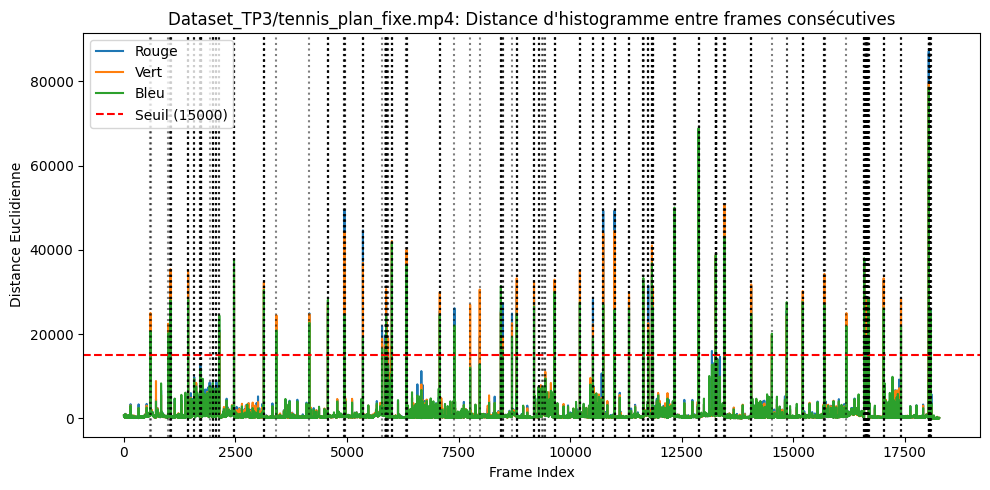

Changements de scène détectés aux frames: [596, 600, 993, 1045, 1045, 1046, 1047, 1048, 1049, 1440, 1440, 1441, 1442, 1443, 1444, 1576, 1577, 1578, 1579, 1715, 1716, 1717, 1718, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1922, 1996, 1997, 1998, 1999, 2000, 2001, 2068, 2069, 2070, 2071, 2072, 2139, 2139, 2140, 2469, 2469, 2470, 2471, 2472, 2473, 3138, 3138, 3139, 3140, 3141, 3142, 3420, 4158, 4573, 4573, 4574, 4575, 4576, 4577, 4944, 4944, 4945, 4946, 4947, 4948, 5359, 5359, 5360, 5361, 5362, 5363, 5787, 5852, 5878, 5878, 5879, 5880, 5881, 5882, 5891, 5894, 5895, 5923, 5927, 6007, 6007, 6008, 6009, 6010, 6011, 6335, 6335, 6336, 6337, 6338, 6339, 7081, 7082, 7083, 7084, 7085, 7411, 7762, 7976, 8451, 8451, 8452, 8453, 8454, 8455, 8490, 8490, 8491, 8700, 8806, 8806, 8807, 8808, 8809, 8810, 9194, 9194, 9195, 9196, 9197, 9198, 9295, 9296, 9297, 9298, 9299, 9383, 9384, 9450, 9451, 9654, 9654, 9655, 9656, 9657, 9658, 10222, 10222, 10223, 10224, 10225, 10226, 10515, 10516, 10517, 10518, 10519, 1

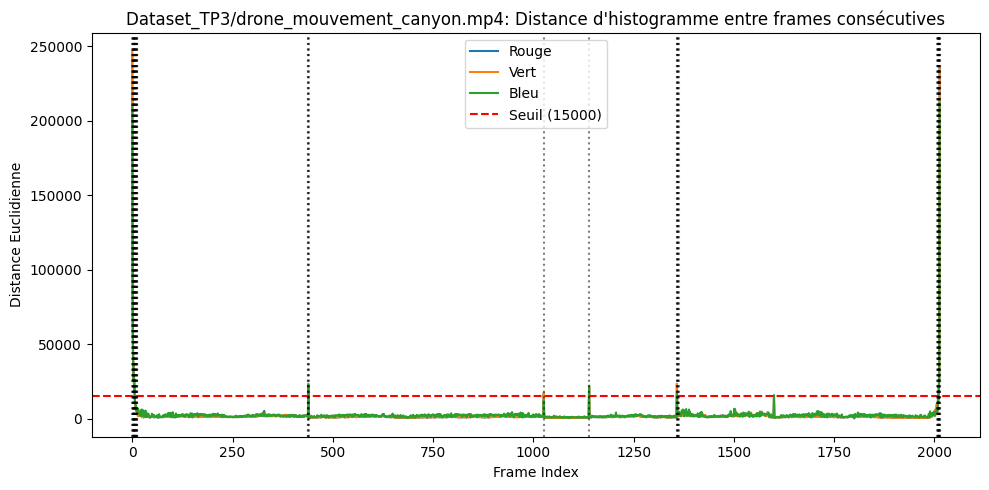

Changements de scène détectés aux frames: [1, 2, 3, 4, 5, 5, 6, 6, 7, 8, 9, 10, 11, 12, 13, 14, 440, 440, 441, 1027, 1140, 1359, 1360, 1361, 1362, 1363, 2008, 2009, 2010, 2011, 2012, 2012, 2013, 2013, 2014, 2014]


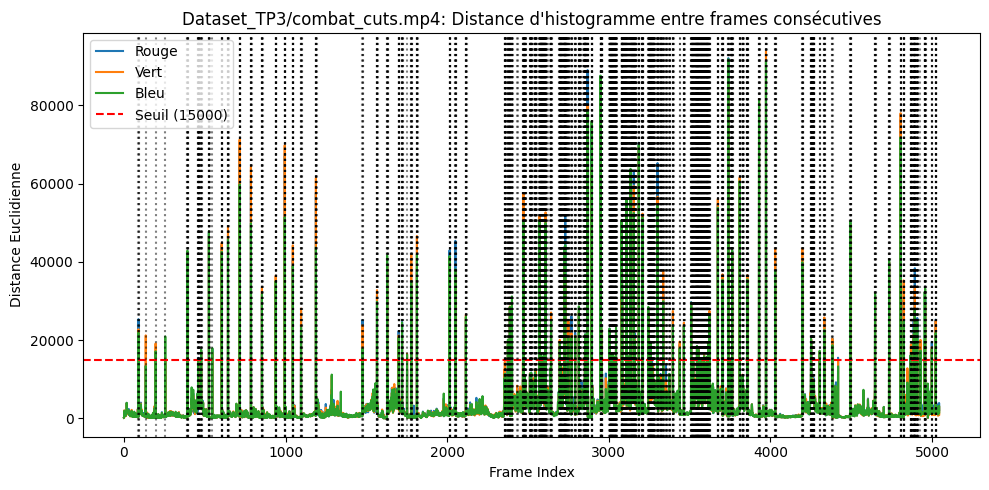

Changements de scène détectés aux frames: [91, 94, 95, 136, 197, 257, 394, 394, 395, 396, 397, 398, 460, 461, 461, 462, 463, 464, 465, 466, 467, 468, 479, 479, 480, 481, 482, 483, 527, 527, 528, 529, 530, 531, 548, 606, 606, 607, 608, 609, 610, 645, 645, 646, 647, 648, 649, 717, 717, 718, 719, 720, 721, 787, 787, 788, 789, 790, 791, 855, 855, 856, 857, 858, 859, 940, 940, 941, 942, 943, 944, 996, 996, 997, 998, 999, 1000, 1046, 1046, 1047, 1048, 1049, 1050, 1097, 1098, 1099, 1100, 1101, 1189, 1189, 1190, 1191, 1192, 1193, 1477, 1480, 1481, 1567, 1567, 1568, 1569, 1570, 1571, 1630, 1630, 1631, 1632, 1633, 1634, 1701, 1701, 1702, 1703, 1704, 1705, 1722, 1722, 1723, 1724, 1725, 1726, 1753, 1779, 1779, 1780, 1781, 1782, 1783, 1814, 1814, 1815, 1816, 1817, 1818, 2016, 2016, 2017, 2018, 2019, 2020, 2052, 2052, 2053, 2054, 2055, 2056, 2117, 2117, 2118, 2119, 2120, 2121, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2377, 2377, 2378, 2379, 2380, 2381, 2389, 2389, 2390, 2391, 2392, 2393

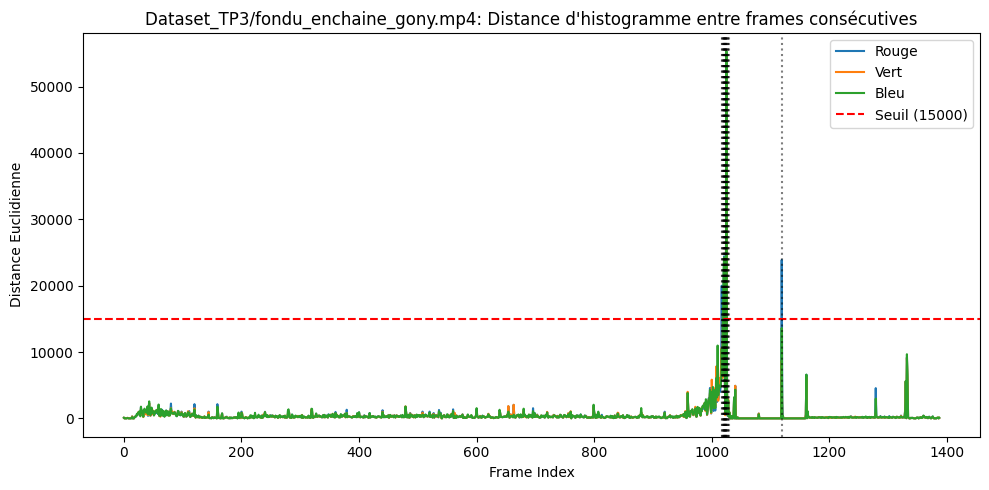

Changements de scène détectés aux frames: [1018, 1019, 1020, 1021, 1021, 1022, 1022, 1023, 1024, 1025, 1025, 1026, 1026, 1027, 1028, 1029, 1030, 1120]


In [17]:
SEUIL = 45000
N = 2
cuts: dict[Path, list[int]] = {}

for histo in histograms:
    frames = histograms[histo]
    distance_r = []
    distance_g = []
    distance_b = []

    scene_changes = []

    WINDOW = 5
    PROG_THRESHOLD = SEUIL * 1.8

    total_distances = []   # <-- DOIT être ici

    for i in range(1, len(frames)):
        prev_r, prev_g, prev_b = frames[i - 1]
        curr_r, curr_g, curr_b = frames[i]

        dist_r = compute_euclidean_distance(prev_r, curr_r)
        dist_g = compute_euclidean_distance(prev_g, curr_g)
        dist_b = compute_euclidean_distance(prev_b, curr_b)

        distance_r.append(dist_r)
        distance_g.append(dist_g)
        distance_b.append(dist_b)

        total_dist = dist_r + dist_g + dist_b
        total_distances.append(total_dist)

        # --- Détection progressive ---
        if i >= WINDOW:
            window_sum = sum(total_distances[i-WINDOW : i])
            if window_sum > PROG_THRESHOLD:
                scene_changes.append(i)

        # --- Détection abrupte ---
        if total_dist > SEUIL:
            scene_changes.append(i)

    cuts[histo] = scene_changes

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(distance_r, label="Rouge")
    plt.plot(distance_g, label="Vert")
    plt.plot(distance_b, label="Bleu")
    plt.axhline(
        y=SEUIL / 3, color="r", linestyle="--", label=f"Seuil ({SEUIL / 3:.0f})"
    )

    for sc in scene_changes:
        plt.axvline(x=sc - 1, color="k", linestyle=":", alpha=0.5)

    plt.xlabel("Frame Index")
    plt.ylabel("Distance Euclidienne")
    plt.title(f"{histo}: Distance d'histogramme entre frames consécutives")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Changements de scène détectés aux frames: {scene_changes}")


In [18]:
DETECTION_THRESHOLD = 1
from pathlib import Path

cuts_path = Path("./cuts")

for cut_name in cuts:
    name_file = cut_name.name.split(".")[0]
    valid_cuts_path = cuts_path / f"{name_file}.txt"

    if not valid_cuts_path.exists():
        print(f"Ground truth file not found: {valid_cuts_path}")
        continue

    valid_cuts_str = open(valid_cuts_path, "r").read()

    valid_cuts = []
    for x in valid_cuts_str.split(","):
        stripped = x.strip()
        if stripped.isdigit():
            valid_cuts.append(int(stripped))

    gen_cuts = cuts[cut_name]

    correct_cuts = []
    incorrect_cuts = []

    for gc in gen_cuts:
        found = False
        for vc in valid_cuts:
            if abs(gc - vc) <= DETECTION_THRESHOLD:
                found = True
                break
        if found:
            correct_cuts.append(gc)
        else:
            incorrect_cuts.append(gc)

    total_detected = len(gen_cuts)

    tp = len(correct_cuts)
    fp = len(incorrect_cuts)
    if (tp + fp) > 0:
        precision = tp / (tp + fp) * 100
    else:
        precision = 0.0

    if total_detected > 0:
        pct_correct = tp / total_detected * 100
        pct_incorrect = fp / total_detected * 100
    else:
        pct_correct = 0.0
        pct_incorrect = 0.0


    if valid_cuts:
        missed_cuts = []
        for vc in valid_cuts:
            detected = any(abs(gc - vc) <= DETECTION_THRESHOLD for gc in gen_cuts)
            if not detected:
                missed_cuts.append(vc)
        recall = (len(valid_cuts) - len(missed_cuts)) / len(valid_cuts) * 100
    else:
        missed_cuts = []
        recall = 0.0

    print(f"\n{'=' * 50}")
    print(f"Vidéo: {cut_name.name}")
    print(f"{'=' * 50}")
    print(f"Cuts détectés: {total_detected} | Ground truth: {len(valid_cuts)}")
    print(f"\n✓ Détections correctes: {len(correct_cuts)} ({pct_correct:.1f}%)")
    print(f"  Frames: {correct_cuts}")
    print(f"\n✗ Faux positifs: {len(incorrect_cuts)} ({pct_incorrect:.1f}%)")
    print(f"  Frames: {incorrect_cuts}")
    print(f"\n⊘ Cuts manqués: {len(missed_cuts)} ({100 - recall:.1f}% du ground truth)")
    print(f"  Frames: {missed_cuts}")
    print(f"\nRappel: {recall:.1f}%")
    print(f"\nPrécision: {precision:.1f}%")

    if precision + recall > 0:
        precision_frac = precision / 100
        recall_frac = recall / 100
        f1 = 2 * (precision_frac * recall_frac) / (precision_frac + recall_frac) * 100
    else:
        f1 = 0.0

    print(f"\nF-score (F1): {f1:.1f}%")


Vidéo: tennis_plan_fixe.mp4
Cuts détectés: 391 | Ground truth: 47

✓ Détections correctes: 81 (20.7%)
  Frames: [1045, 1045, 1440, 1440, 2139, 2139, 2469, 2469, 3138, 3138, 3420, 4158, 4573, 4573, 4944, 4944, 5359, 5359, 5787, 5852, 5878, 5878, 6007, 6007, 6335, 6335, 7081, 7411, 7762, 7976, 8451, 8451, 8490, 8490, 8700, 8806, 8806, 9194, 9194, 9654, 9654, 10222, 10222, 10515, 10745, 10745, 10998, 10998, 11323, 11323, 11644, 11644, 11754, 11754, 11837, 11837, 11860, 11860, 12342, 12342, 12882, 12882, 13462, 13462, 14062, 14062, 14525, 14858, 15217, 15217, 15703, 15703, 15704, 16197, 16595, 16595, 16692, 16692, 17031, 17031, 17420]

✗ Faux positifs: 310 (79.3%)
  Frames: [596, 600, 993, 1046, 1047, 1048, 1049, 1441, 1442, 1443, 1444, 1576, 1577, 1578, 1579, 1715, 1716, 1717, 1718, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1922, 1996, 1997, 1998, 1999, 2000, 2001, 2068, 2069, 2070, 2071, 2072, 2140, 2470, 2471, 2472, 2473, 3139, 3140, 3141, 3142, 4574, 4575, 4576, 4577, 4945, 4946, 4947